# DeepLabCut Process Position

## Dhruv Mehrotra, 2022


In this notebook, we will learn how to analyze position data from a given sub-region of your environment. In particular, this example deals with a mouse running on the radial arm maze, but the idea can be generalized to the analysis of a given sub-region of any environment. 


Let's get right into it! First, import the necessary libraries.

In [1]:
import pynapple as nap

import numpy as np
import pandas as pd
import scipy.io
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *


Next, load the data from your directory. My data is being read from an h5 file, but this can be replaced to read whatever format you are working with (csv, MAT file etc).

In [2]:
data_directory = '/media/DataDhruv/Recordings/unimplanted/211231'
tracking_data =  pd.read_hdf(data_directory + '/' + '1819-211231_1.h5', mode = 'r')

tracking_data


scorer    DLC_mobnet_100_unimplantedJan4shuffle1_200000              \
bodyparts                                          nose               
coords                                                x           y   
0                                            325.915680   87.834717   
1                                            330.679016   92.426193   
2                                            330.229675   92.469246   
3                                            324.419312   85.861443   
4                                            324.482239   87.202263   
...                                                 ...         ...   
154432                                       991.857971  175.494125   
154433                                       991.476501  174.963913   
154434                                       991.720520  175.118958   
154435                                       328.655090   86.512009   
154436                                       991.879517  174.817444   

scorer                                                                \
bodyparts                leftear                            rightear   
coords    likelihood           x            y likelihood           x   
0           0.047951  327.809082    89.872162   0.031015  383.521667   
1           0.005103  111.054222  1007.833008   0.006857  384.808868   
2           0.003538  991.470459   573.574402   0.003131  384.428528   
3           0.028133  328.421967    90.776245   0.030893  384.233154   
4           0.014028  327.500519    90.704430   0.016099  384.890259   
...              ...         ...          ...        ...         ...   
154432      0.001959  423.084625   199.708374   0.001155  384.718536   
154433      0.001489  991.325317   573.928833   0.001893  384.466309   
154434      0.001419  417.429535   191.197449   0.001276  386.694214   
154435      0.001663  314.363403   -13.260569   0.001334  384.249390   
154436      0.001389  422.413788   196.893265   0.002721  386.354828   

scorer                            
bodyparts                         
coords              y likelihood  
0          158.932144   0.019942  
1          158.491882   0.008222  
2          158.548752   0.012223  
3          157.995850   0.030514  
4          158.675751   0.016726  
...               ...        ...  
154432     157.750381   0.002946  
154433     157.800858   0.005548  
154434     157.707367   0.031571  
154435     158.987778   0.011806  
154436     157.463684   0.075369  

[154437 rows x 9 columns]

Here, we see that tracking_data has 9 columns. Namely, the x and y positions of the 3 bodyparts I labelled (nose, left ear and right ear), as well as the likelihood. We are only interested in the x and y positions, so we will extract these, and create a new DataFrame, with just the relevant data.

In [3]:
hd_cols = [0,1,3,4,6,7]
hd_data = tracking_data.iloc[:,hd_cols]

hd_data

scorer    DLC_mobnet_100_unimplantedJan4shuffle1_200000              \
bodyparts                                          nose               
coords                                                x           y   
0                                            325.915680   87.834717   
1                                            330.679016   92.426193   
2                                            330.229675   92.469246   
3                                            324.419312   85.861443   
4                                            324.482239   87.202263   
...                                                 ...         ...   
154432                                       991.857971  175.494125   
154433                                       991.476501  174.963913   
154434                                       991.720520  175.118958   
154435                                       328.655090   86.512009   
154436                                       991.879517  174.817444   

scorer                                                      
bodyparts     leftear                 rightear              
coords              x            y           x           y  
0          327.809082    89.872162  383.521667  158.932144  
1          111.054222  1007.833008  384.808868  158.491882  
2          991.470459   573.574402  384.428528  158.548752  
3          328.421967    90.776245  384.233154  157.995850  
4          327.500519    90.704430  384.890259  158.675751  
...               ...          ...         ...         ...  
154432     423.084625   199.708374  384.718536  157.750381  
154433     991.325317   573.928833  384.466309  157.800858  
154434     417.429535   191.197449  386.694214  157.707367  
154435     314.363403   -13.260569  384.249390  158.987778  
154436     422.413788   196.893265  386.354828  157.463684  

[154437 rows x 6 columns]

Now, from this data shall compute the centroid of these 3 body parts. This will result in a proxy for head position.
The centroid or geometric center is the arithmetic mean position of all the points (in our case, the ears and the nose).

First, we select the columns containing the x-and y-coordinates of all parts. We will store these in x_cols and y_cols, respectively. Then create a new DataFrame with just the x-coordinate and y-coordinates, which we call "all_x_coords" and "all_y_coords" respectively. 

In [4]:
x_cols = [0,2,4]
y_cols = [1,3,5]
all_x_coords = hd_data.iloc[:,x_cols]
all_y_coords = hd_data.iloc[:,y_cols]
all_x_coords

scorer    DLC_mobnet_100_unimplantedJan4shuffle1_200000              \
bodyparts                                          nose     leftear   
coords                                                x           x   
0                                            325.915680  327.809082   
1                                            330.679016  111.054222   
2                                            330.229675  991.470459   
3                                            324.419312  328.421967   
4                                            324.482239  327.500519   
...                                                 ...         ...   
154432                                       991.857971  423.084625   
154433                                       991.476501  991.325317   
154434                                       991.720520  417.429535   
154435                                       328.655090  314.363403   
154436                                       991.879517  422.413788   

scorer                 
bodyparts    rightear  
coords              x  
0          383.521667  
1          384.808868  
2          384.428528  
3          384.233154  
4          384.890259  
...               ...  
154432     384.718536  
154433     384.466309  
154434     386.694214  
154435     384.249390  
154436     386.354828  

[154437 rows x 3 columns]

Wonderful! Now to compute the centroid. Remember, it is a mean. Therefore, we need the sum of the observations for each time point. We compute the sums for each coordinate separately, below:  

In [5]:
x_sum = all_x_coords.sum(axis = 1)
y_sum = all_y_coords.sum(axis = 1)

x_sum

0         1037.246429
1          826.542107
2         1706.128662
3         1037.074432
4         1036.873016
             ...     
154432    1799.661133
154433    2367.268127
154434    1795.844269
154435    1027.267883
154436    1800.648132
Length: 154437, dtype: float64

Now, we need to divide the sum by the number of body parts. In our case this is 3, but we will express this in more general terms so that we do not hard-code our variables. Remember, it is good practice to write the most generalizable code. 

In [6]:
length = all_x_coords.iloc[0,:].shape[0]

Now, we will compute the centroid, and store it in a DataFrame called hd_centroid. From here, we will extract the X and Y positions of the head, stored in the variables x and y, respectively.

In [7]:
x_cent = x_sum/length
y_cent = y_sum/length

hd_centroid = np.zeros((len(x_cent),2))
hd_centroid[:,0] = x_cent 
hd_centroid[:,1] = y_cent

x = hd_centroid[:,0]
y = hd_centroid[:,1]


Now, let us create a DataFrame for position. Time to use Pynapple! This recording was acquired at 120Hz, so we will make the timestamps first, as below: 

In [8]:
fs = 120
timestamps = x_cent.index.values/fs
    

Now, we create the position DataFrame as below: 

In [9]:
position = np.vstack([x, y]).T
position = nap.TsdFrame(t = timestamps, d = position, columns = ['x', 'y'], time_units = 's')

position


,x,y
Time (s),,
0.000000,345.748810,112.213008
0.008333,275.514036,419.583694
0.016667,568.709554,274.864133
0.025000,345.691477,111.544512
0.033333,345.624339,112.194148
...,...,...
1286.933333,599.887044,177.650960
1286.941667,789.089376,302.231201
1286.950000,598.614756,174.674591


This looks good, but does not give us an idea of what the data really represents. Let's plot this

<AxesSubplot:>

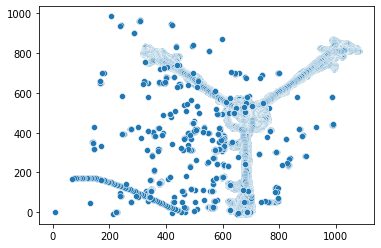

In [10]:
sns.scatterplot(data = position, x = x, y = y)

Aha! What we said before is now evident. The position plot reveals the radial arm maze outline. There are some points outside the bounds of the maze, due to DeepLabCut detecting the mouse erroneously. But these point are irrelevant to us, since we only care about points in the centre of the maze. Now, I will define the centre point of the maze, using the coordinates (xth, yth) and a radius of the circle given by rth.

(xth, yth) are approximate values for the centre of this maze. Feel free to pick these values as per your convenience and application. rth is also modifiable as per your application.

We will go with the following parameter values:

In [11]:
xth = 683.4
yth = 484.4
rth = 200

Let us visualize this; we will plot the position with the circle around it. And then we will only consider those trajectories that lie within the circle.

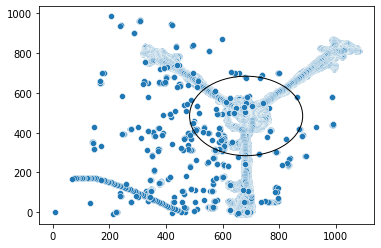

In [12]:
circle1 = plt.Circle((xth, yth), rth, color='k', fill = False)
ax = sns.scatterplot(data = position, x = x, y = y)
ax.add_patch(circle1)

Great! So now we can restrict our position data to the centre of the maze. 

So, to do this, firstly, we will restrict our position to points within the centre. This can be done by selecting points whose distance from the centre is smaller than the radius of our circle. Time to put Pynapple to use!

In [13]:
d = np.sqrt((x - xth)**2 + (y - yth)**2)
dist_center = nap.Tsd(t = timestamps, d = d, time_units = 's')

dist_center

Time (s)
0.000000       502.525107
0.008333       413.003769
0.016667       238.870630
0.025000       503.058904
0.033333       502.622715
                  ...    
1286.933333    317.914119
1286.941667    210.607966
1286.950000    321.120486
1286.958333    530.946257
1286.966667    319.043616
Length: 154437, dtype: float64

Pynapple time!

In [14]:
within_center = dist_center.threshold(rth, 'below')
ep = within_center.time_support

within_center

Time (s)
0.041667       111.789845
0.050000       112.349458
0.233333       112.429611
0.250000       198.200149
0.316667       195.779983
                  ...    
1286.775000    191.168783
1286.783333    172.081024
1286.816667    191.184213
1286.841667    190.762090
1286.916667    191.413067
Length: 84709, dtype: float64

As you can see, all values in within_center are now less than our threshold value (rth). 

What does the time support of this look like?

In [15]:
print(ep)

           start          end
0       0.037500     0.054167
1       0.229166     0.237500
2       0.245833     0.254166
3       0.312500     0.320834
4       0.470834     0.479166
..           ...          ...
213  1286.737500  1286.745834
214  1286.770834  1286.787500
215  1286.812500  1286.820834
216  1286.837500  1286.845834
217  1286.912500  1286.920833

[218 rows x 2 columns]


So now we have a set of points for when the animal is within the radius of the maze. We will now seaparate these points into trials. For our purposes, we will say that trials that are only greater than 0.7s be considered. Additionally, each trial can have a maximal duration of 20s. 

In [16]:
ep = ep.drop_short_intervals(0.7, time_units = 's')

ep

,start,end
0,3.712500,4.804166
1,6.695834,7.912500
2,9.329166,12.562500
3,17.812500,18.612500
4,22.937500,23.829166
...,...,...
5,1037.437500,1040.520834
6,1048.729166,1051.954167
7,1075.654166,1078.345834
8,1089.045833,1091.445834


In [17]:
ep = ep.drop_long_intervals(20, time_units = 's')
ep = ep.reset_index(drop=True)
ep

,start,end
0,3.712500,4.804166
1,6.695834,7.912500
2,9.329166,12.562500
3,17.812500,18.612500
4,22.937500,23.829166
...,...,...
5,1034.495834,1035.462500
6,1037.437500,1040.520834
7,1048.729166,1051.954167
8,1075.654166,1078.345834


Now, we will plot the trajectories corresponding to our trials: 

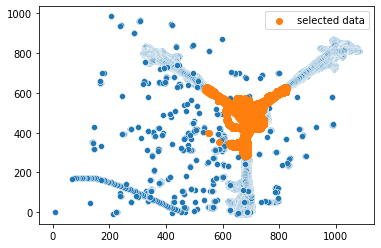

In [18]:
plt.figure()
sns.scatterplot(data = position, x = x, y = y)
plt.scatter(position['x'].restrict(ep), position['y'].restrict(ep), zorder = 2, label = 'selected data')
plt.legend(loc = 'upper right')

And voila! We have now obtained the trajectory of the animal within the circle of interest!

We can also go one step ahead and consider only those trials where the animal goes from the departure arm to any arm "in front" of it. We call these "forward trials". To determine what constitutes a forward trial, we use the following logic: 

1. Any trajectory where the y-position at the end of the trial is larger than the y-position at the start of the trial.

2. Any trajectory where the y-position at the end of the trial is larger than the radius of our circle.  

So, first we define the change in y-position as a Pynapple Tsd: 

In [19]:
dy = nap.Tsd(t = timestamps, d = y-yth, time_units = 's')  


Now, we will compute the variable diffy using the 2 conditions mentioned above.

In [20]:
diffy = []
for i in ep.index.values:
    tmp = dy.restrict(ep.loc[[i]])
    diffy.append(tmp.iloc[-1] - tmp.iloc[0])
diffy = pd.Series(data = diffy)
diffy2 = diffy[diffy > rth/2]
    
ep_fwd = ep.loc[diffy2.index]

ep_fwd

,start,end
0,3.712500,4.804166
1,17.812500,18.612500
2,45.120834,46.187500
3,54.229167,54.954166
4,78.929167,79.795834
5,119.229166,120.279166
6,151.295834,152.462500
7,193.704166,194.629166
8,220.104166,221.595834
9,252.279166,253.362500


We are left with a subset of epochs that are forward trials. Let us now visualize this: 

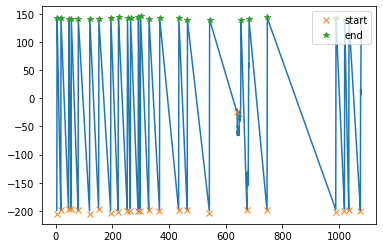

In [21]:
start = nap.Ts(ep_fwd['start'].values)
ends = nap.Ts(ep_fwd['end'].values)

plt.plot(dy.restrict(ep_fwd))
plt.plot(start.value_from(dy).index.values, start.value_from(dy).values ,'x', label = 'start')
plt.plot(ends.value_from(dy).index.values, ends.value_from(dy).values ,'*', label = 'end')
plt.legend(loc = 'upper right')


This plot shows us that the trials we have are indeed forward trials; y-position at the start of the trial is lower than the y-position at the end of the trial.

Now, you can save these variables as a CSV file, to use with your other analysis scripts.

I hope this tutorial was helpful. If you have any questions, comments or suggestions, please feel free to reach out to the Pynacollada Team! 